# Practico Mentoria - Aprendizaje Supervisado

Vamos a tratar de predecir el resultado de un partido para el equipo local, es decir, si el equipo local gana (**Win**), empata (**Draw**) o pierde (**Lose**).

---

### Importaciones

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from utils import plot_confusion_matrix

In [3]:
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [4]:
# Seteamos una semilla para Reproducibilidad
np.random.seed(42)

---

### Carga del Dateset

In [5]:
data_df = pd.read_csv('./Datasets/football_data.csv')

print("Shape 'data_df'  = {}".format(data_df.shape))

Shape 'data_df'  = (322, 37)


In [6]:
data_df.head()

,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won,games_against_lost,League_21518,League_24558,home_player_1_overall_rating,home_player_2_overall_rating,...,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating,B365_Win,B365_Draw,B365_Lose,BW_Win,BW_Draw,BW_Lose,label
0,-5,-8,2,1,0,0,1,0,77.0,69.0,...,71.0,73.0,73.0,0.395683,0.287770,0.316547,0.389704,0.287782,0.322514,Draw
1,4,-2,4,1,0,0,1,0,76.0,79.0,...,76.0,71.0,72.0,0.624582,0.238903,0.136516,0.612713,0.253365,0.133922,Draw
2,18,7,6,6,0,0,1,0,81.0,81.0,...,78.0,90.0,88.0,0.390698,0.260465,0.348837,0.380496,0.279776,0.339728,Lose
3,1,1,2,3,0,0,1,0,79.0,65.0,...,81.0,81.0,79.0,0.360875,0.287606,0.351519,0.354839,0.290323,0.354839,Win
4,1,1,3,1,0,0,1,0,74.0,73.0,...,67.0,76.0,76.0,0.651526,0.223380,0.125093,0.634855,0.224066,0.141079,Draw


In [7]:
data_df.dtypes

home_team_goals_difference         int64
away_team_goals_difference         int64
games_won_home_team                int64
games_won_away_team                int64
games_against_won                  int64
games_against_lost                 int64
League_21518                       int64
League_24558                       int64
home_player_1_overall_rating     float64
home_player_2_overall_rating     float64
home_player_3_overall_rating     float64
home_player_4_overall_rating     float64
home_player_5_overall_rating     float64
home_player_6_overall_rating     float64
home_player_7_overall_rating     float64
home_player_8_overall_rating     float64
home_player_9_overall_rating     float64
home_player_10_overall_rating    float64
home_player_11_overall_rating    float64
away_player_1_overall_rating     float64
away_player_2_overall_rating     float64
away_player_3_overall_rating     float64
away_player_4_overall_rating     float64
away_player_5_overall_rating     float64
away_player_6_ov

### Obtemos el `input` y el `target` para los modelos

> Obtenemos el `target`

In [8]:
target_data = data_df.loc[:, 'label']

In [9]:
print("Shape 'target_data' = {}".format(target_data.shape))
display(target_data.head())
print('=' * 30)
display(target_data.dtypes)

Shape 'target_data' = (322,)


0    Draw
1    Draw
2    Lose
3     Win
4    Draw
Name: label, dtype: object

dtype('O')

In [10]:
target_data.unique()

array(['Draw', 'Lose', 'Win'], dtype=object)

Win     155
Lose     90
Draw     77
Name: label, dtype: int64

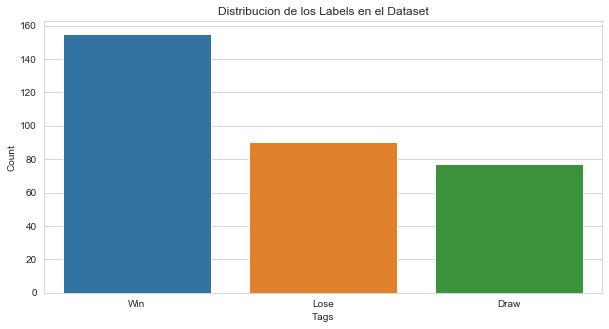

In [12]:
# TODO: Plotear la distribucion de los targets

plt.figure(figsize=(10, 5))

target_count = target_data.value_counts()
display(target_count)
my_order = ["Win", "Lose", "Draw"]

sns.barplot(target_count.index, target_count.values, order=my_order)
plt.title('Distribucion de los Labels en el Dataset')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.show()

> Obtenemos el `input_data`

In [13]:
input_data = data_df.drop('label', axis=1)

In [15]:
print("Shape 'input_data' = {}".format(input_data.shape))
display(input_data.head())
print('=' * 30)
display(input_data.dtypes)

Shape 'input_data' = (322, 36)


,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won,games_against_lost,League_21518,League_24558,home_player_1_overall_rating,home_player_2_overall_rating,...,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating,B365_Win,B365_Draw,B365_Lose,BW_Win,BW_Draw,BW_Lose
0,-5,-8,2,1,0,0,1,0,77.0,69.0,...,72.0,71.0,73.0,73.0,0.395683,0.287770,0.316547,0.389704,0.287782,0.322514
1,4,-2,4,1,0,0,1,0,76.0,79.0,...,74.0,76.0,71.0,72.0,0.624582,0.238903,0.136516,0.612713,0.253365,0.133922
2,18,7,6,6,0,0,1,0,81.0,81.0,...,88.0,78.0,90.0,88.0,0.390698,0.260465,0.348837,0.380496,0.279776,0.339728
3,1,1,2,3,0,0,1,0,79.0,65.0,...,79.0,81.0,81.0,79.0,0.360875,0.287606,0.351519,0.354839,0.290323,0.354839
4,1,1,3,1,0,0,1,0,74.0,73.0,...,69.0,67.0,76.0,76.0,0.651526,0.223380,0.125093,0.634855,0.224066,0.141079


home_team_goals_difference         int64
away_team_goals_difference         int64
games_won_home_team                int64
games_won_away_team                int64
games_against_won                  int64
games_against_lost                 int64
League_21518                       int64
League_24558                       int64
home_player_1_overall_rating     float64
home_player_2_overall_rating     float64
home_player_3_overall_rating     float64
home_player_4_overall_rating     float64
home_player_5_overall_rating     float64
home_player_6_overall_rating     float64
home_player_7_overall_rating     float64
home_player_8_overall_rating     float64
home_player_9_overall_rating     float64
home_player_10_overall_rating    float64
home_player_11_overall_rating    float64
away_player_1_overall_rating     float64
away_player_2_overall_rating     float64
away_player_3_overall_rating     float64
away_player_4_overall_rating     float64
away_player_5_overall_rating     float64
away_player_6_ov

> ### División de datos en conjuntos de Entrenamiento, Validacion y Test

La primer tarea consiste en dividir el conjunto de datos cargado en el apartado anterior en conjuntos de Entrenamiento (o _training_), Validacion (_validation_) y evaluación (o _test_).

Utilizar aproximadamente 70% de los datos para Entrenamiento, 20% para Validacion y el 10% para Evaluacion.

Links:
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [39]:
# TODO

X_entrenamiento, X_evaluacion, y_entrenamiento, y_evaluacion = train_test_split(input_data, target_data, test_size=0.2)
X_entr, X_val, y_entr, y_val = train_test_split(X_entrenamiento, y_entrenamiento, test_size=0.123)


In [41]:
print('forma de las matrices de X')
print (X_evaluacion.shape)
print (X_entr.shape)
print (X_val.shape)

print('forma de las matrices de Y')
print (y_evaluacion.shape)
print (y_entr.shape)
print (y_val.shape)



forma de las matrices de X
(65, 36)
(225, 36)
(32, 36)
forma de las matrices de Y
(65,)
(225,)
(32,)


> ### Distribucion de los labels en los conjuntos de datos generados

Mostrar en un grafico, como se distribuyen los labels en los conjuntos de datos generados.

**Hint**: Usar graficos de barra (_bar plot_).

Win     113
Lose     60
Draw     52
Name: label, dtype: int64

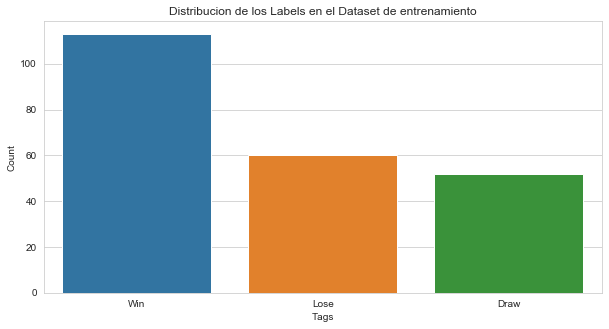

In [42]:
# TODO
plt.figure(figsize=(10, 5))

target_count = y_entr.value_counts()
display(target_count)
my_order = ["Win", "Lose", "Draw"]

sns.barplot(target_count.index, target_count.values, order=my_order)
plt.title('Distribucion de los Labels en el Dataset de entrenamiento')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.show()

Win     15
Draw    10
Lose     7
Name: label, dtype: int64

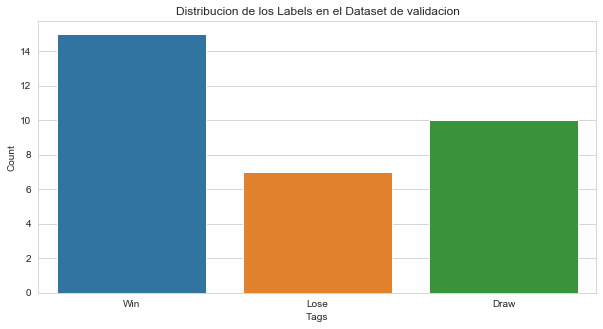

In [43]:
plt.figure(figsize=(10, 5))

target_count = y_val.value_counts()
display(target_count)
my_order = ["Win", "Lose", "Draw"]

sns.barplot(target_count.index, target_count.values, order=my_order)
plt.title('Distribucion de los Labels en el Dataset de validacion')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.show()

Win     27
Lose    23
Draw    15
Name: label, dtype: int64

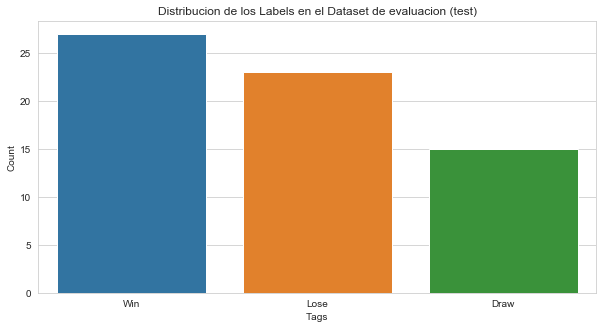

In [44]:
plt.figure(figsize=(10, 5))

target_count = y_evaluacion.value_counts()
display(target_count)
my_order = ["Win", "Lose", "Draw"]

sns.barplot(target_count.index, target_count.values, order=my_order)
plt.title('Distribucion de los Labels en el Dataset de evaluacion (test)')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.show()

> ### Modelo Baseline

Implementar un modelo Baseline usando, por ejemplo **Logistic Regression** sin ajuste de Hiperparametros.

Calcular la accuracy en los conjuntos de entrenamiento y validacion.

In [45]:
# TODO
model_baseline = LogisticRegression()
model_baseline.fit(X_entr, y_entr)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_entr, model_baseline.predict(X_entr)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model_baseline.predict(X_val)))



Exactitud para entrenamiento: 0.64
Exactitud para validación: 0.34


> ### Seleccion de Clasificadores

Comparar la performance entre clasificadores:
* [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
* [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
* [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

**Hint** para mejores resultados:
* Usar [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) y [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

> **Plotear los resultados en un grafico**

In [50]:
test_score_dict = {}

scaler = StandardScaler()
X_entr_sca = scaler.fit_transform(X_entr)
X_val_sca = scaler.transform(X_val)
X_evaluacion_sca = scaler.transform(X_evaluacion)

pca = PCA(n_components=4)


pca_x_entr = pca.fit_transform(X_entr_sca)
pca_x_val = pca.fit_transform(X_val_sca)
pca_x_eval = pca.fit_transform(X_evaluacion_sca)

print('varianza')
pca.explained_variance_ratio_

varianza


array([0.39214983, 0.28411407, 0.04757339, 0.03165779])

> ### 1. Random Forest

In [52]:
# TODO

parameters = {
    'n_estimators': [5,10,15,20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,3,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

randomForest = RandomForestClassifier()
grid_RandomForest = GridSearchCV(randomForest, parameters, cv=5, scoring='accuracy')
grid_RandomForest.fit(pca_x_entr, y_entr)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [53]:
print('mejor score: ', grid_RandomForest.best_score_)
print('mejor estimador: ', grid_RandomForest.best_estimator_)
print('mejores parametros: ', grid_RandomForest.best_params_)

mejor score:  0.5866666666666667
mejor estimador:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
mejores parametros:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 15}


In [57]:
acc_train = accuracy_score(y_entr, grid_RandomForest.predict(pca_x_entr))
acc_valid = accuracy_score(y_val, grid_RandomForest.predict(pca_x_val))

print('accuracy para entrenamiento: ', acc_train)
print('accuracy para validacion: ', acc_valid)



accuracy para entrenamiento:  0.6133333333333333
accuracy para validacion:  0.34375


> ### 2. Ada Boost

In [55]:
# TODO

parameters = {
    'n_estimators': [5,10,15,20,50,100,200],
    'algorithm'  : ['SAMME','SAMME.R']
}

adaBoost = AdaBoostClassifier()
grid_Ada = GridSearchCV(adaBoost, parameters, cv=5, scoring='accuracy')
grid_Ada.fit(pca_x_entr, y_entr)

print('mejor score: ', grid_Ada.best_score_)
print('mejor estimador: ', grid_Ada.best_estimator_)
print('mejores parametros: ', grid_Ada.best_params_)

mejor score:  0.5688888888888889
mejor estimador:  AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
                   n_estimators=15, random_state=None)
mejores parametros:  {'algorithm': 'SAMME', 'n_estimators': 15}


In [58]:
acc_train = accuracy_score(y_entr, grid_Ada.predict(pca_x_entr))
acc_valid = accuracy_score(y_val, grid_Ada.predict(pca_x_val))

print('accuracy para entrenamiento: ', acc_train)
print('accuracy para validacion: ', acc_valid)



accuracy para entrenamiento:  0.6088888888888889
accuracy para validacion:  0.375


> ### 3. K-Neighbors

In [ ]:
# TODO

> ### 4. Logistic Regression

In [ ]:
# TODO

> ### Matriz de Confusion

Plotear la matriz de confusion del mejor modelo sobre el conjunto de **Test**.

**Hint**: Usar la funcion `plot_confusion_matrix` del modulo `utils`.

In [ ]:
# TODO

> ### Classification Report

Imprimir el `classification_report` y explicar lo que refleja este reporte.

In [ ]:
# TODO

---

**Comunicación de Resultados**

Se pide que toda esta información no quede plasmada solamente en un Jupyter Notebook, sino que se diagrame una comunicación en formato textual o interactivo (Google Docs, PDF o Markdown por ejemplo).

La comunicación debe estar apuntada a un público técnico pero sin conocimiento del tema particular, como por ejemplo, sus compañeros de clase.